In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ====== 15-PUZZLE SETUP ======
GRID_SIZE = 4

def create_solved_puzzle():
    """Create the goal state: tiles 1-15 in order, 0 (empty) at bottom-right."""
    tiles = []
    for i in range(GRID_SIZE):
        row = []
        for j in range(GRID_SIZE):
            row.append(i * GRID_SIZE + j + 1)
        tiles.append(row)
    tiles[GRID_SIZE - 1][GRID_SIZE - 1] = 0  # Empty tile
    return tiles

def find_empty_pos(tiles):
    """Find the position of the empty tile (0)."""
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if tiles[i][j] == 0:
                return (i, j)
    return None

def scramble_puzzle(num_moves=20):
    """Generate a solvable puzzle by applying random moves from the solved state."""
    tiles = create_solved_puzzle()
    empty_pos = find_empty_pos(tiles)
    
    last_move = -1
    for _ in range(num_moves):
        valid_moves = []
        for direction in range(4):
            # Avoid undoing the last move (direction ^ 1 gives opposite)
            if can_move(tiles, empty_pos, direction) and direction != (last_move ^ 1):
                valid_moves.append(direction)
        
        if valid_moves:
            move = random.choice(valid_moves)
            tiles, empty_pos = apply_move(tiles, empty_pos, move)
            last_move = move
    
    return tiles

def can_move(tiles, empty_pos, direction):
    """Check if a move is valid. Directions: 0=up, 1=down, 2=left, 3=right."""
    row, col = empty_pos
    if direction == 0:  # up
        return row > 0
    elif direction == 1:  # down
        return row < GRID_SIZE - 1
    elif direction == 2:  # left
        return col > 0
    elif direction == 3:  # right
        return col < GRID_SIZE - 1
    return False

def apply_move(tiles, empty_pos, direction):
    """Apply a move and return new state and empty position."""
    tiles = [row[:] for row in tiles]  # Deep copy
    row, col = empty_pos
    
    if direction == 0:  # up
        new_row, new_col = row - 1, col
    elif direction == 1:  # down
        new_row, new_col = row + 1, col
    elif direction == 2:  # left
        new_row, new_col = row, col - 1
    elif direction == 3:  # right
        new_row, new_col = row, col + 1
    
    # Swap
    tiles[row][col] = tiles[new_row][new_col]
    tiles[new_row][new_col] = 0
    
    return tiles, (new_row, new_col)

def manhattan_distance(tiles):
    """Calculate Manhattan distance heuristic."""
    dist = 0
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            value = tiles[i][j]
            if value != 0:
                target_row = (value - 1) // GRID_SIZE
                target_col = (value - 1) % GRID_SIZE
                dist += abs(i - target_row) + abs(j - target_col)
    return dist

def is_solved(tiles):
    """Check if puzzle is in goal state."""
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            expected = i * GRID_SIZE + j + 1
            if i == GRID_SIZE - 1 and j == GRID_SIZE - 1:
                if tiles[i][j] != 0:
                    return False
            else:
                if tiles[i][j] != expected:
                    return False
    return True

def state_to_string(tiles):
    """Convert state to string for Q-table key."""
    return ','.join(str(tiles[i][j]) for i in range(GRID_SIZE) for j in range(GRID_SIZE))

def print_puzzle(tiles):
    """Pretty print the puzzle."""
    for row in tiles:
        print(' '.join(f'{val:2}' if val != 0 else ' .' for val in row))
    print()

# Test basic functions
print("Solved puzzle:")
solved = create_solved_puzzle()
print_puzzle(solved)
print(f"Manhattan distance: {manhattan_distance(solved)}")
print(f"Is solved: {is_solved(solved)}")

print("\nScrambled puzzle (20 moves):")
scrambled = scramble_puzzle(20)
print_puzzle(scrambled)
print(f"Manhattan distance: {manhattan_distance(scrambled)}")
print(f"Is solved: {is_solved(scrambled)}")

Solved puzzle:
 1  2  3  4
 5  6  7  8
 9 10 11 12
13 14 15  .

Manhattan distance: 0
Is solved: True

Scrambled puzzle (20 moves):
 1  2  3  4
 9  5  6  .
10 12 15  7
13 14  8 11

Manhattan distance: 14
Is solved: False


In [12]:
# ====== RL ENVIRONMENT ======
class PuzzleEnvironment:
    def __init__(self, initial_tiles):
        self.initial_tiles = [row[:] for row in initial_tiles]
        self.reset()
    
    def reset(self):
        self.tiles = [row[:] for row in self.initial_tiles]
        self.empty_pos = find_empty_pos(self.tiles)
        return self.tiles
    
    def step(self, action):
        """Take action, return (next_state, reward, done)."""
        if not can_move(self.tiles, self.empty_pos, action):
            return self.tiles, -5, False
        
        prev_dist = manhattan_distance(self.tiles)
        self.tiles, self.empty_pos = apply_move(self.tiles, self.empty_pos, action)
        curr_dist = manhattan_distance(self.tiles)
        done = is_solved(self.tiles)
        
        if done:
            reward = 100
        else:
            progress = prev_dist - curr_dist
            reward = progress * 2 - 0.1
        
        return self.tiles, reward, done
    
    def get_valid_actions(self):
        """Return list of valid actions."""
        return [a for a in range(4) if can_move(self.tiles, self.empty_pos, a)]

# Test environment
print("Testing environment...")
test_puzzle = scramble_puzzle(10)
env = PuzzleEnvironment(test_puzzle)
print("Initial state:")
print_puzzle(env.tiles)
print(f"Valid actions: {env.get_valid_actions()}")

# Take a random action
action = random.choice(env.get_valid_actions())
next_state, reward, done = env.step(action)
print(f"\nAfter action {action} (0=up, 1=down, 2=left, 3=right):")
print_puzzle(next_state)
print(f"Reward: {reward:.2f}, Done: {done}")

Testing environment...
Initial state:
 1  2  3  4
 5  .  6  7
 9 10 15  8
13 14 12 11

Valid actions: [0, 1, 2, 3]

After action 2 (0=up, 1=down, 2=left, 3=right):
 1  2  3  4
 .  5  6  7
 9 10 15  8
13 14 12 11

Reward: -2.10, Done: False


In [13]:
# ====== RL UTILITIES ======
def init_Q():
    return {}

def get_Q_values(Q, state_str, optimistic_init=0):
    if state_str not in Q:
        Q[state_str] = [optimistic_init] * 4
    return Q[state_str]

def eps_greedy(Q, state, epsilon, env, optimistic_init=10):
    state_str = state_to_string(state)
    
    if random.random() < epsilon:
        # Random valid action
        valid_actions = env.get_valid_actions()
        return random.choice(valid_actions)
    
    # Greedy: choose best valid action
    q_values = get_Q_values(Q, state_str, optimistic_init)
    valid_actions = env.get_valid_actions()
    
    best_action = valid_actions[0]
    best_value = q_values[best_action]
    
    for action in valid_actions:
        if q_values[action] > best_value:
            best_value = q_values[action]
            best_action = action
    
    return best_action

# Q-Learning Implementation

In [14]:
def q_learning(env, alpha=0.2, gamma=0.9, epsilon_start=0.3, epsilon_end=0.05, episodes=2000):
    Q = init_Q()
    steps_per_episode = []
    success_per_episode = []
    optimistic_init = 10
    
    for ep in range(episodes):
        # Epsilon decay
        epsilon = max(epsilon_end, epsilon_start * (1 - ep / episodes))
        
        state = env.reset()
        done = False
        steps = 0
        max_steps = 200
        
        while not done and steps < max_steps:
            state_str = state_to_string(state)
            action = eps_greedy(Q, state, epsilon, env, optimistic_init)
            
            next_state, reward, done = env.step(action)
            
            next_state_str = state_to_string(next_state)
            q_next = get_Q_values(Q, next_state_str, optimistic_init)
            max_q_next = max(q_next)
            
            q_curr = get_Q_values(Q, state_str, optimistic_init)
            q_curr[action] += alpha * (reward + gamma * max_q_next - q_curr[action])
            
            state = next_state
            steps += 1
        
        steps_per_episode.append(steps)
        success_per_episode.append(1 if done else 0)
        
        if (ep + 1) % 500 == 0:
            recent_success = sum(success_per_episode[-100:]) / 100
            print(f"Episode {ep + 1}/{episodes}, Success Rate (last 100): {recent_success:.2%}")
    
    return Q, steps_per_episode, success_per_episode

# SARSA Implementation

In [15]:
def sarsa(env, alpha=0.2, gamma=0.9, epsilon_start=0.3, epsilon_end=0.05, episodes=2000):
    Q = init_Q()
    steps_per_episode = []
    success_per_episode = []
    optimistic_init = 10
    
    for ep in range(episodes):
        epsilon = max(epsilon_end, epsilon_start * (1 - ep / episodes))
        
        state = env.reset()
        state_str = state_to_string(state)
        action = eps_greedy(Q, state, epsilon, env, optimistic_init)
        done = False
        steps = 0
        max_steps = 200
        
        while not done and steps < max_steps:
            next_state, reward, done = env.step(action)
            
            next_state_str = state_to_string(next_state)
            next_action = eps_greedy(Q, next_state, epsilon, env, optimistic_init)
            
            q_curr = get_Q_values(Q, state_str, optimistic_init)
            q_next = get_Q_values(Q, next_state_str, optimistic_init)
            q_curr[action] += alpha * (reward + gamma * q_next[next_action] - q_curr[action])
            
            state = next_state
            state_str = next_state_str
            action = next_action
            steps += 1
        
        steps_per_episode.append(steps)
        success_per_episode.append(1 if done else 0)
        
        if (ep + 1) % 500 == 0:
            recent_success = sum(success_per_episode[-100:]) / 100
            print(f"Episode {ep + 1}/{episodes}, Success Rate (last 100): {recent_success:.2%}")
    
    return Q, steps_per_episode, success_per_episode

# Monte Carlo Implementation (First-Visit)

In [16]:
def monte_carlo(env, alpha=0.2, gamma=0.9, epsilon_start=0.3, epsilon_end=0.05, episodes=2000):
    Q = init_Q()
    steps_per_episode = []
    success_per_episode = []
    optimistic_init = 10
    
    for ep in range(episodes):
        epsilon = max(epsilon_end, epsilon_start * (1 - ep / episodes))
        
        state = env.reset()
        episode = []
        done = False
        steps = 0
        max_steps = 200
        
        # Generate episode
        while not done and steps < max_steps:
            state_str = state_to_string(state)
            action = eps_greedy(Q, state, epsilon, env, optimistic_init)
            next_state, reward, done = env.step(action)
            
            episode.append((state_str, action, reward))
            state = next_state
            steps += 1
        
        steps_per_episode.append(steps)
        success_per_episode.append(1 if done else 0)
        
        # Update Q-values
        G = 0
        visited = set()
        
        for t in range(len(episode) - 1, -1, -1):
            state_str, action, reward = episode[t]
            G = gamma * G + reward
            
            sa_key = (state_str, action)
            if sa_key not in visited:
                visited.add(sa_key)
                q_values = get_Q_values(Q, state_str, optimistic_init)
                q_values[action] += alpha * (G - q_values[action])
        
        if (ep + 1) % 500 == 0:
            recent_success = sum(success_per_episode[-100:]) / 100
            print(f"Episode {ep + 1}/{episodes}, Success Rate (last 100): {recent_success:.2%}")
    
    return Q, steps_per_episode, success_per_episode

# Training All Algorithms

In [17]:
# Generate a scrambled puzzle
print("Generating scrambled puzzle (20 moves)...")
initial_puzzle = scramble_puzzle(20)
print("Initial puzzle:")
print_puzzle(initial_puzzle)
print(f"Manhattan distance: {manhattan_distance(initial_puzzle)}\n")

# Train Q-Learning
print("\n=== Training Q-Learning ===")
env_q = PuzzleEnvironment(initial_puzzle)
Q_q, steps_q, success_q = q_learning(env_q, episodes=2000)

# Train SARSA
print("\n=== Training SARSA ===")
env_sarsa = PuzzleEnvironment(initial_puzzle)
Q_sarsa, steps_sarsa, success_sarsa = sarsa(env_sarsa, episodes=2000)

# Train Monte Carlo
print("\n=== Training Monte Carlo ===")
env_mc = PuzzleEnvironment(initial_puzzle)
Q_mc, steps_mc, success_mc = monte_carlo(env_mc, episodes=2000)

print("\nTraining complete!")

Generating scrambled puzzle (20 moves)...
Initial puzzle:
 2  6  3  8
 5  1  4 11
13  9  7 10
14  . 15 12

Manhattan distance: 16


=== Training Q-Learning ===
Episode 500/2000, Success Rate (last 100): 0.00%
Episode 500/2000, Success Rate (last 100): 0.00%
Episode 1000/2000, Success Rate (last 100): 0.00%
Episode 1000/2000, Success Rate (last 100): 0.00%
Episode 1500/2000, Success Rate (last 100): 0.00%
Episode 1500/2000, Success Rate (last 100): 0.00%
Episode 2000/2000, Success Rate (last 100): 0.00%

=== Training SARSA ===
Episode 2000/2000, Success Rate (last 100): 0.00%

=== Training SARSA ===
Episode 500/2000, Success Rate (last 100): 0.00%
Episode 500/2000, Success Rate (last 100): 0.00%
Episode 1000/2000, Success Rate (last 100): 10.00%
Episode 1000/2000, Success Rate (last 100): 10.00%
Episode 1500/2000, Success Rate (last 100): 9.00%
Episode 1500/2000, Success Rate (last 100): 9.00%
Episode 2000/2000, Success Rate (last 100): 98.00%

=== Training Monte Carlo ===
Episode 2000/

# Visualizing Results

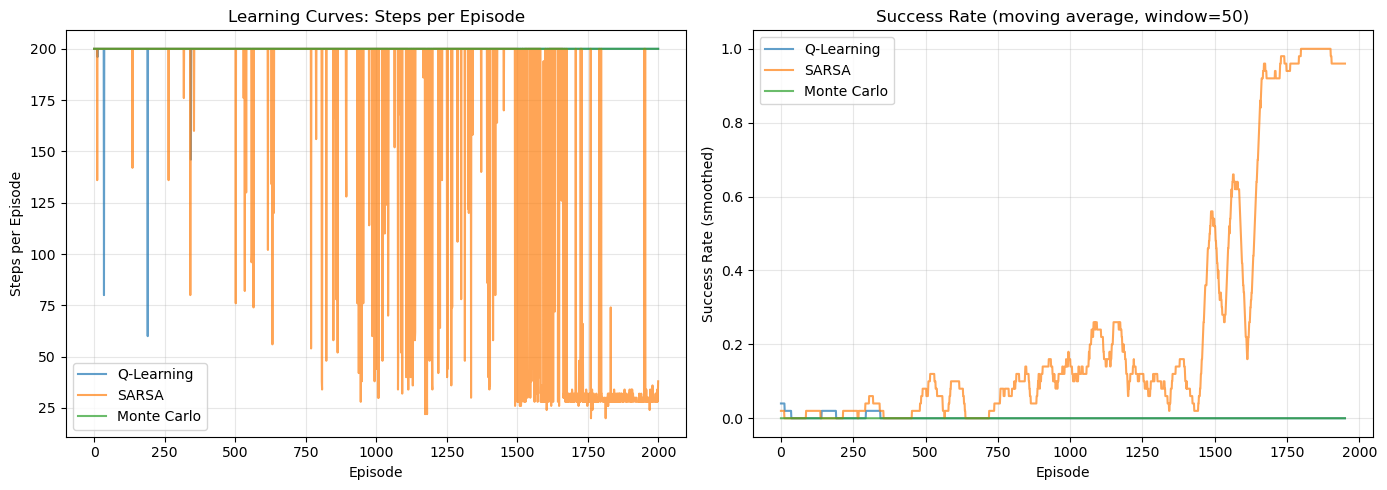


=== Final Statistics ===

Q-Learning:
  Overall Success Rate: 0.20%
  Avg Steps per Episode: 199.84
  Last 100 Success Rate: 0.00%

SARSA:
  Overall Success Rate: 25.15%
  Avg Steps per Episode: 160.41
  Last 100 Success Rate: 98.00%

Monte Carlo:
  Overall Success Rate: 0.00%
  Avg Steps per Episode: 200.00
  Last 100 Success Rate: 0.00%


In [18]:
# Plot learning curves
plt.figure(figsize=(14, 5))

# Steps per episode
plt.subplot(1, 2, 1)
plt.plot(steps_q, label='Q-Learning', alpha=0.7)
plt.plot(steps_sarsa, label='SARSA', alpha=0.7)
plt.plot(steps_mc, label='Monte Carlo', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Steps per Episode')
plt.title('Learning Curves: Steps per Episode')
plt.legend()
plt.grid(True, alpha=0.3)

# Success rate (smoothed)
plt.subplot(1, 2, 2)
window = 50

def smooth(data, window):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.plot(smooth(success_q, window), label='Q-Learning', alpha=0.7)
plt.plot(smooth(success_sarsa, window), label='SARSA', alpha=0.7)
plt.plot(smooth(success_mc, window), label='Monte Carlo', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Success Rate (smoothed)')
plt.title(f'Success Rate (moving average, window={window})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("\n=== Final Statistics ===")
print(f"\nQ-Learning:")
print(f"  Overall Success Rate: {sum(success_q) / len(success_q) * 100:.2f}%")
print(f"  Avg Steps per Episode: {np.mean(steps_q):.2f}")
print(f"  Last 100 Success Rate: {sum(success_q[-100:]) / 100 * 100:.2f}%")

print(f"\nSARSA:")
print(f"  Overall Success Rate: {sum(success_sarsa) / len(success_sarsa) * 100:.2f}%")
print(f"  Avg Steps per Episode: {np.mean(steps_sarsa):.2f}")
print(f"  Last 100 Success Rate: {sum(success_sarsa[-100:]) / 100 * 100:.2f}%")

print(f"\nMonte Carlo:")
print(f"  Overall Success Rate: {sum(success_mc) / len(success_mc) * 100:.2f}%")
print(f"  Avg Steps per Episode: {np.mean(steps_mc):.2f}")
print(f"  Last 100 Success Rate: {sum(success_mc[-100:]) / 100 * 100:.2f}%")

# Testing Learned Policies

In [19]:
def test_policy(Q, initial_puzzle, max_steps=200, algorithm_name="Agent"):
    """Test a learned policy and visualize the solution path."""
    env = PuzzleEnvironment(initial_puzzle)
    state = env.reset()
    done = False
    steps = 0
    
    print(f"\n=== Testing {algorithm_name} Policy ===")
    print("\nInitial state:")
    print_puzzle(state)
    
    path = [state]
    
    while not done and steps < max_steps:
        state_str = state_to_string(state)
        q_values = get_Q_values(Q, state_str, 10)
        
        # Choose best valid action
        valid_actions = env.get_valid_actions()
        best_action = valid_actions[0]
        best_value = q_values[best_action]
        
        for action in valid_actions:
            if q_values[action] > best_value:
                best_value = q_values[action]
                best_action = action
        
        next_state, reward, done = env.step(best_action)
        state = next_state
        steps += 1
        path.append(state)
    
    print(f"\nFinal state after {steps} steps:")
    print_puzzle(state)
    
    if done:
        print(f"✓ {algorithm_name} solved the puzzle in {steps} steps!")
    else:
        print(f"✗ {algorithm_name} did not solve the puzzle within {max_steps} steps.")
        print(f"   Final Manhattan distance: {manhattan_distance(state)}")
    
    return done, steps

# Test all three algorithms
test_policy(Q_q, initial_puzzle, algorithm_name="Q-Learning")
test_policy(Q_sarsa, initial_puzzle, algorithm_name="SARSA")
test_policy(Q_mc, initial_puzzle, algorithm_name="Monte Carlo")


=== Testing Q-Learning Policy ===

Initial state:
 2  6  3  8
 5  1  4 11
13  9  7 10
14  . 15 12


Final state after 200 steps:
 2  6  3  8
 5  1  4  .
 9  7 10 11
13 14 15 12

✗ Q-Learning did not solve the puzzle within 200 steps.
   Final Manhattan distance: 12

=== Testing SARSA Policy ===

Initial state:
 2  6  3  8
 5  1  4 11
13  9  7 10
14  . 15 12


Final state after 28 steps:
 1  2  3  4
 5  6  7  8
 9 10 11 12
13 14 15  .

✓ SARSA solved the puzzle in 28 steps!

=== Testing Monte Carlo Policy ===

Initial state:
 2  6  3  8
 5  1  4 11
13  9  7 10
14  . 15 12


Final state after 200 steps:
 2  6  3  8
 5  7  1  4
 9 10 11 12
13 14 15  .

✗ Monte Carlo did not solve the puzzle within 200 steps.
   Final Manhattan distance: 8


(False, 200)

# Finding Convergence Episodes

In [20]:
def find_convergence_episode(success_list, window_size=100, threshold=0.7):
    """Find the first episode where success rate over next window_size episodes exceeds threshold."""
    for i in range(len(success_list) - window_size + 1):
        window_success = success_list[i:i + window_size]
        window_rate = sum(window_success) / window_size
        if window_rate > threshold:
            return i + 1  # Return 1-indexed episode
    return None

print("\n=== Convergence Analysis ===")

conv_q = find_convergence_episode(success_q)
if conv_q:
    print(f"Q-Learning converged at episode {conv_q}")
else:
    print(f"Q-Learning did not converge (final success rate: {sum(success_q[-100:]) / 100 * 100:.2f}%)")

conv_sarsa = find_convergence_episode(success_sarsa)
if conv_sarsa:
    print(f"SARSA converged at episode {conv_sarsa}")
else:
    print(f"SARSA did not converge (final success rate: {sum(success_sarsa[-100:]) / 100 * 100:.2f}%)")

conv_mc = find_convergence_episode(success_mc)
if conv_mc:
    print(f"Monte Carlo converged at episode {conv_mc}")
else:
    print(f"Monte Carlo did not converge (final success rate: {sum(success_mc[-100:]) / 100 * 100:.2f}%)")


=== Convergence Analysis ===
Q-Learning did not converge (final success rate: 0.00%)
SARSA converged at episode 1638
Monte Carlo did not converge (final success rate: 0.00%)
